In [1]:
# from hugging face 
!pip3 install diffusers  

In [2]:
pip install -U transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip3 install datasets

     -------------------------------------- 507.1/507.1 kB 8.0 MB/s eta 0:00:00
     ------------------------------------- 364.6/364.6 kB 22.2 MB/s eta 0:00:00
     -------------------------------------- 134.8/134.8 kB 8.3 MB/s eta 0:00:00
     -------------------------------------- 166.4/166.4 kB 9.8 MB/s eta 0:00:00
     --------------------------------------- 24.8/24.8 MB 29.8 MB/s eta 0:00:00
     ---------------------------------------- 76.4/76.4 kB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 50.4/50.4 kB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 115.3/115.3 kB ? eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.12.2
    Uninstalling fsspec-2023.12.2:
      Successfully uninstalled fsspec-2023.12.2
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [6]:
pip install accelerate


     -------------------------------------- 270.9/270.9 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random 
import timeit

In [9]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [20]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
print (dataset.shape)

c:\Users\imran\anaconda3\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


(1000, 18)


C:\Users\imran\AppData\Local\Temp\ipykernel_7444\2340717843.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


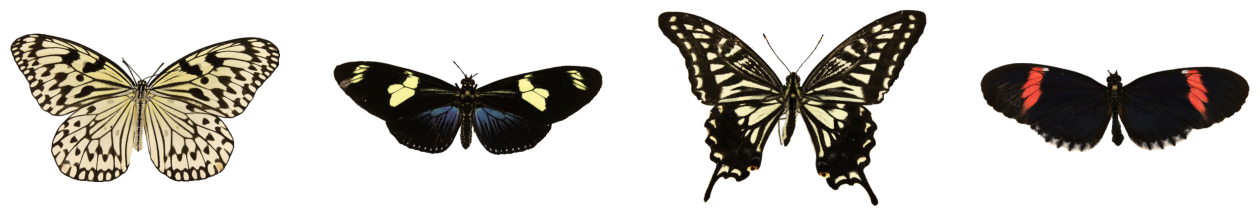

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [12]:
preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [14]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 128, 128])
Output shape torch.Size([1, 3, 128, 128])


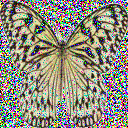

In [15]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0])

In [16]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1955, device='cuda:0', grad_fn=<MseLossBackward0>)


In [17]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

100%|██████████| 63/63 [00:41<00:00,  1.51it/s]

------------------------------
Train Loss EPOCH: 1: 0.8643
Train Learning Rate EPOCH: 1: 1.2600000000000001e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

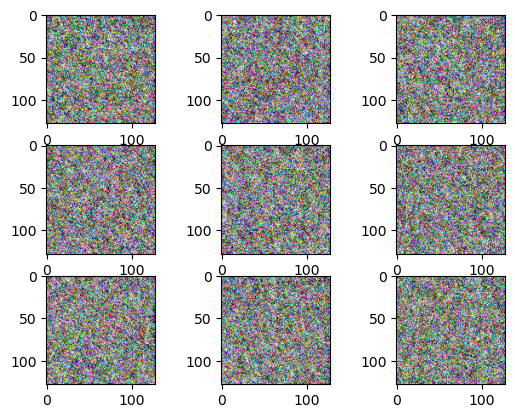

  2%|▏         | 1/50 [01:57<1:36:06, 117.69s/it]

------------------------------


  4%|▍         | 2/50 [02:38<58:10, 72.72s/it]   

------------------------------
Train Loss EPOCH: 2: 0.1621
Train Learning Rate EPOCH: 2: 2.5200000000000003e-05
------------------------------


  6%|▌         | 3/50 [03:20<45:48, 58.47s/it]

------------------------------
Train Loss EPOCH: 3: 0.0749
Train Learning Rate EPOCH: 3: 3.7800000000000004e-05
------------------------------


  8%|▊         | 4/50 [04:01<39:33, 51.60s/it]

------------------------------
Train Loss EPOCH: 4: 0.0614
Train Learning Rate EPOCH: 4: 5.0400000000000005e-05
------------------------------


 10%|█         | 5/50 [04:42<35:52, 47.83s/it]

------------------------------
Train Loss EPOCH: 5: 0.0494
Train Learning Rate EPOCH: 5: 6.3e-05
------------------------------


 12%|█▏        | 6/50 [05:23<33:22, 45.52s/it]

------------------------------
Train Loss EPOCH: 6: 0.0432
Train Learning Rate EPOCH: 6: 7.560000000000001e-05
------------------------------


 14%|█▍        | 7/50 [06:04<31:36, 44.11s/it]

------------------------------
Train Loss EPOCH: 7: 0.0356
Train Learning Rate EPOCH: 7: 8.82e-05
------------------------------


 16%|█▌        | 8/50 [06:46<30:18, 43.29s/it]

------------------------------
Train Loss EPOCH: 8: 0.0313
Train Learning Rate EPOCH: 8: 9.999943783063545e-05
------------------------------


 18%|█▊        | 9/50 [07:28<29:12, 42.75s/it]

------------------------------
Train Loss EPOCH: 9: 0.0279
Train Learning Rate EPOCH: 9: 9.984235896746403e-05
------------------------------


 20%|██        | 10/50 [08:09<28:08, 42.21s/it]

------------------------------
Train Loss EPOCH: 10: 0.0229
Train Learning Rate EPOCH: 10: 9.940738186432565e-05
------------------------------


100%|██████████| 63/63 [00:40<00:00,  1.54it/s]

------------------------------
Train Loss EPOCH: 11: 0.0232
Train Learning Rate EPOCH: 11: 9.869693175497514e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

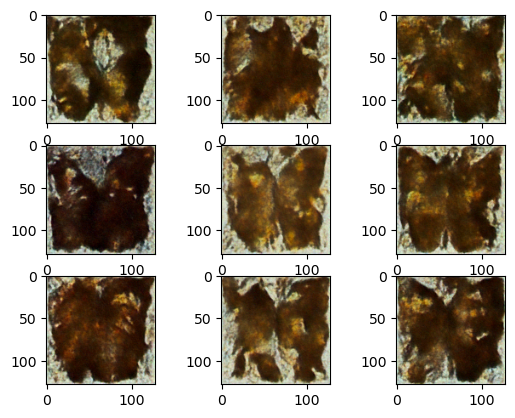

 22%|██▏       | 11/50 [10:07<42:36, 65.54s/it]

------------------------------


 24%|██▍       | 12/50 [10:48<36:50, 58.16s/it]

------------------------------
Train Loss EPOCH: 12: 0.0274
Train Learning Rate EPOCH: 12: 9.771496978489323e-05
------------------------------


 26%|██▌       | 13/50 [11:29<32:39, 52.96s/it]

------------------------------
Train Loss EPOCH: 13: 0.0254
Train Learning Rate EPOCH: 13: 9.646697092574766e-05
------------------------------


 28%|██▊       | 14/50 [12:10<29:38, 49.40s/it]

------------------------------
Train Loss EPOCH: 14: 0.0251
Train Learning Rate EPOCH: 14: 9.495989344945056e-05
------------------------------


 30%|███       | 15/50 [12:52<27:22, 46.92s/it]

------------------------------
Train Loss EPOCH: 15: 0.0226
Train Learning Rate EPOCH: 15: 9.320214013201078e-05
------------------------------


 32%|███▏      | 16/50 [13:33<25:37, 45.21s/it]

------------------------------
Train Loss EPOCH: 16: 0.0225
Train Learning Rate EPOCH: 16: 9.120351140349089e-05
------------------------------


 34%|███▍      | 17/50 [14:14<24:09, 43.93s/it]

------------------------------
Train Loss EPOCH: 17: 0.0206
Train Learning Rate EPOCH: 17: 8.897515070528305e-05
------------------------------


 36%|███▌      | 18/50 [14:55<22:57, 43.05s/it]

------------------------------
Train Loss EPOCH: 18: 0.0199
Train Learning Rate EPOCH: 18: 8.652948235936705e-05
------------------------------


 38%|███▊      | 19/50 [15:36<21:57, 42.49s/it]

------------------------------
Train Loss EPOCH: 19: 0.0188
Train Learning Rate EPOCH: 19: 8.388014229596275e-05
------------------------------


 40%|████      | 20/50 [16:17<21:01, 42.04s/it]

------------------------------
Train Loss EPOCH: 20: 0.0162
Train Learning Rate EPOCH: 20: 8.104190202580812e-05
------------------------------


100%|██████████| 63/63 [00:40<00:00,  1.54it/s]

------------------------------
Train Loss EPOCH: 21: 0.0173
Train Learning Rate EPOCH: 21: 7.803058628095877e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

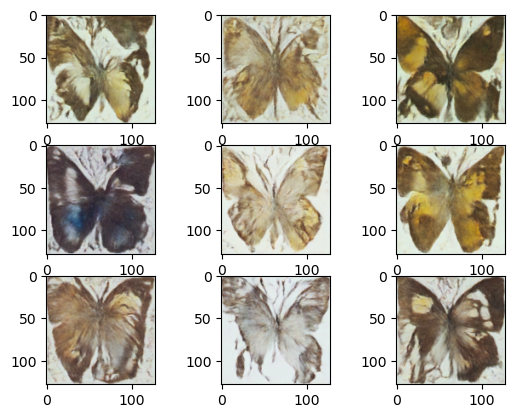

 42%|████▏     | 21/50 [18:12<30:53, 63.93s/it]

------------------------------


 44%|████▍     | 22/50 [18:53<26:37, 57.05s/it]

------------------------------
Train Loss EPOCH: 22: 0.0211
Train Learning Rate EPOCH: 22: 7.486298478330615e-05
------------------------------


 46%|████▌     | 23/50 [19:34<23:33, 52.34s/it]

------------------------------
Train Loss EPOCH: 23: 0.0195
Train Learning Rate EPOCH: 23: 7.155675863275306e-05
------------------------------


 48%|████▊     | 24/50 [20:15<21:12, 48.93s/it]

------------------------------
Train Loss EPOCH: 24: 0.0200
Train Learning Rate EPOCH: 24: 6.813034183698301e-05
------------------------------


 50%|█████     | 25/50 [20:56<19:25, 46.63s/it]

------------------------------
Train Loss EPOCH: 25: 0.0190
Train Learning Rate EPOCH: 25: 6.460283853184879e-05
------------------------------


 52%|█████▏    | 26/50 [21:38<17:59, 44.97s/it]

------------------------------
Train Loss EPOCH: 26: 0.0191
Train Learning Rate EPOCH: 26: 6.0993916465432213e-05
------------------------------


 54%|█████▍    | 27/50 [22:19<16:49, 43.88s/it]

------------------------------
Train Loss EPOCH: 27: 0.0178
Train Learning Rate EPOCH: 27: 5.732369733965931e-05
------------------------------


 56%|█████▌    | 28/50 [23:00<15:46, 43.04s/it]

------------------------------
Train Loss EPOCH: 28: 0.0172
Train Learning Rate EPOCH: 28: 5.361264462087627e-05
------------------------------


 58%|█████▊    | 29/50 [23:40<14:45, 42.18s/it]

------------------------------
Train Loss EPOCH: 29: 0.0165
Train Learning Rate EPOCH: 29: 4.9881449444902904e-05
------------------------------


 60%|██████    | 30/50 [24:20<13:51, 41.55s/it]

------------------------------
Train Loss EPOCH: 30: 0.0142
Train Learning Rate EPOCH: 30: 4.615091525270501e-05
------------------------------


100%|██████████| 63/63 [00:40<00:00,  1.57it/s]

------------------------------
Train Loss EPOCH: 31: 0.0151
Train Learning Rate EPOCH: 31: 4.244184179990459e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

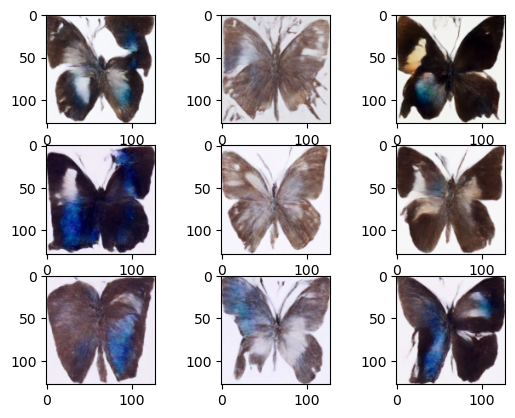

 62%|██████▏   | 31/50 [26:14<20:02, 63.31s/it]

------------------------------


 64%|██████▍   | 32/50 [26:54<16:54, 56.35s/it]

------------------------------
Train Loss EPOCH: 32: 0.0186
Train Learning Rate EPOCH: 32: 3.87749091868379e-05
------------------------------


 66%|██████▌   | 33/50 [27:35<14:34, 51.47s/it]

------------------------------
Train Loss EPOCH: 33: 0.0174
Train Learning Rate EPOCH: 33: 3.517056255575659e-05
------------------------------


 68%|██████▊   | 34/50 [28:15<12:48, 48.06s/it]

------------------------------
Train Loss EPOCH: 34: 0.0181
Train Learning Rate EPOCH: 34: 3.164889809804808e-05
------------------------------


 70%|███████   | 35/50 [28:55<11:25, 45.67s/it]

------------------------------
Train Loss EPOCH: 35: 0.0171
Train Learning Rate EPOCH: 35: 2.822955100704634e-05
------------------------------


 72%|███████▏  | 36/50 [29:35<10:17, 44.09s/it]

------------------------------
Train Loss EPOCH: 36: 0.0168
Train Learning Rate EPOCH: 36: 2.4931586001157835e-05
------------------------------


 74%|███████▍  | 37/50 [30:15<09:18, 42.93s/it]

------------------------------
Train Loss EPOCH: 37: 0.0162
Train Learning Rate EPOCH: 37: 2.1773391027694734e-05
------------------------------


 76%|███████▌  | 38/50 [30:55<08:24, 42.08s/it]

------------------------------
Train Loss EPOCH: 38: 0.0158
Train Learning Rate EPOCH: 38: 1.8772574740075105e-05
------------------------------


 78%|███████▊  | 39/50 [31:36<07:37, 41.55s/it]

------------------------------
Train Loss EPOCH: 39: 0.0153
Train Learning Rate EPOCH: 39: 1.5945868320010076e-05
------------------------------


 80%|████████  | 40/50 [32:16<06:51, 41.10s/it]

------------------------------
Train Loss EPOCH: 40: 0.0131
Train Learning Rate EPOCH: 40: 1.3309032192072463e-05
------------------------------


100%|██████████| 63/63 [00:39<00:00,  1.58it/s]

------------------------------
Train Loss EPOCH: 41: 0.0140
Train Learning Rate EPOCH: 41: 1.0876768150764277e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

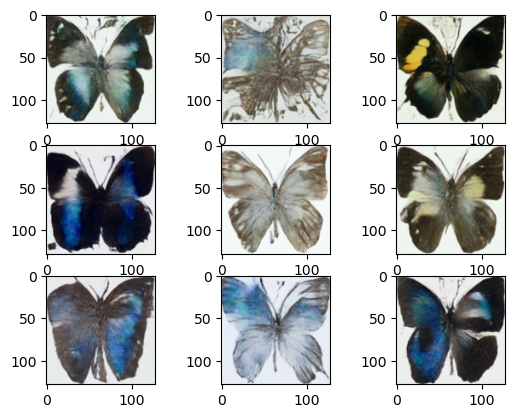

 82%|████████▏ | 41/50 [34:07<09:18, 62.07s/it]

------------------------------


 84%|████████▍ | 42/50 [34:47<07:24, 55.57s/it]

------------------------------
Train Loss EPOCH: 42: 0.0173
Train Learning Rate EPOCH: 42: 8.66263739002211e-06
------------------------------


 86%|████████▌ | 43/50 [35:27<05:56, 50.95s/it]

------------------------------
Train Loss EPOCH: 43: 0.0162
Train Learning Rate EPOCH: 43: 6.678984892190559e-06
------------------------------


 88%|████████▊ | 44/50 [36:08<04:47, 47.84s/it]

------------------------------
Train Loss EPOCH: 44: 0.0170
Train Learning Rate EPOCH: 44: 4.9368705980363415e-06
------------------------------


 90%|█████████ | 45/50 [36:49<03:49, 45.82s/it]

------------------------------
Train Loss EPOCH: 45: 0.0161
Train Learning Rate EPOCH: 45: 3.4460077415675474e-06
------------------------------


 92%|█████████▏| 46/50 [37:30<02:57, 44.43s/it]

------------------------------
Train Loss EPOCH: 46: 0.0157
Train Learning Rate EPOCH: 46: 2.214708693475065e-06
------------------------------


 94%|█████████▍| 47/50 [38:11<02:10, 43.47s/it]

------------------------------
Train Loss EPOCH: 47: 0.0154
Train Learning Rate EPOCH: 47: 1.2498386151482467e-06
------------------------------


 96%|█████████▌| 48/50 [38:53<01:25, 42.73s/it]

------------------------------
Train Loss EPOCH: 48: 0.0152
Train Learning Rate EPOCH: 48: 5.567771816690381e-07
------------------------------


 98%|█████████▊| 49/50 [39:34<00:42, 42.25s/it]

------------------------------
Train Loss EPOCH: 49: 0.0147
Train Learning Rate EPOCH: 49: 1.3938858719967363e-07
------------------------------


100%|██████████| 50/50 [40:15<00:00, 48.31s/it]

------------------------------
Train Loss EPOCH: 50: 0.0127
Train Learning Rate EPOCH: 50: 0.0
------------------------------
Training Time: 2415.39s


In [18]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)
    
    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

In [9]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import cv2
import numpy as np


img_path = r'C:\dataset\processed_p_salekin\video_subjects\1_I4C1B1F1E1V#P0_sub016_vid03_seg_01-3-of-4\face\Iframe018.png'
raw_image = np.array(Image.open(img_path))
# imgc = cv2.resize(imgc, (224, 224))
# img_floatt = np.float32(imgc) / 255
# print(img_floatt.shape)
# input_tensorr = preprocess_image(img_floatt, mean=[0.4277, 0.3931, 0.3794], std=[0.1858, 0.1925, 0.1941])
# print(input_tensorr.shape)



processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")



# conditional image captioning
text = "a photography of "
inputs = processor(raw_image, text, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

a photography of a baby is holding a bottle of water
there is a baby that is holding a bottle in his hand
